In [63]:
import sys
sys.path.append('/home/sensei/jupy-notebooks/Analytics/PorterFarms/')
print("============================================")
print("/  MoteIntervalArrivalTimes is running.    /")
print("============================================")

import requests
from datetime import datetime, timedelta
import pytz
from slackclient import SlackClient
import json
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import configparser
from pandas.plotting import register_matplotlib_converters


config = configparser.ConfigParser()
config.read("../../../analytics_secrets.ini")

_ACTIVE_STANDBY = config['DEFAULT']['role']
if _ACTIVE_STANDBY == 'STANDBY':
    # the DB SERVER is the active node - it can't run the MoteHealth NB
    print("STANDBY")
    raise SystemExit("Stop right there!")
else:
  _SLACK_TOKEN = config['slack']['token']
  _CHIRPSTACK_HOST = config['chirpstack']['host']
  _CHIRPSTACK_USER = config['chirpstack']['user']
  _CHIRPSTACK_PASS = config['chirpstack']['password']
  _DB_HOST  = config['kanjidb']['dbhost']
  _DB_PORT  = config['kanjidb']['dbport']
  _DB_NAME  = config['kanjidb']['dbname']
  _DB_USER  = config['kanjidb']['dbuser']
  _DB_PASS  = config['kanjidb']['dbpass']

  _SLACK_SYSTEMCHANNEL_NAME = config['analytics']['systemchannelname']
  _SLACK_SYSTEMCHANNEL_DBID = int(config['analytics']['systemchannelid'])

  _USE_DROPBOX   = config['dropbox']['usedropbox']
  _FALLBACK_IMAGE = config['dropbox']['fallbackimage']

  _UTC_OFFSET = int(config['DEFAULT']['utcoffset'])

  _LOG_DEBUG = 0
  _LOG_INFO  = 1
  _LOG_ERROR = 2
  _LOG_LEVEL = int(config['DEFAULT']['loglevel'])
def logger(level, message):
    if level >= _LOG_LEVEL:
      print(message)

logger(_LOG_DEBUG, "{} {} {} {} {}".format(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS))

import kanjiticketing as kt

conn = kt.getKanjiDbConnection(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS)
if conn is not None:
  print("Welcome to Jupyter Notebook.  You are connected to the Kanji database!")
else:
  print("You are not connected to the database.")

messagetemplate = "[\
   {\"type\": \"section\", \
		\"text\": { \
			\"type\": \"mrkdwn\", \
			\"text\": \"*<fakeLink.toUserProfiles.com|Iris / Zelda 1-1>*\\nTuesday, January 21 4:00-4:30pm\\nBuilding 2 - Havarti Cheese (3)\\n2 guests\" \
		}, \
		\"accessory\": { \
			\"type\": \"image\", \
			\"image_url\": \"https://api.slack.com/img/blocks/bkb_template_images/notifications.png\", \
			\"alt_text\": \"calendar thumbnail\" \
		} \
   } ]"

/  MoteIntervalArrivalTimes is running.    /
Welcome to Jupyter Notebook.  You are connected to the Kanji database!


Mote agMote-20002


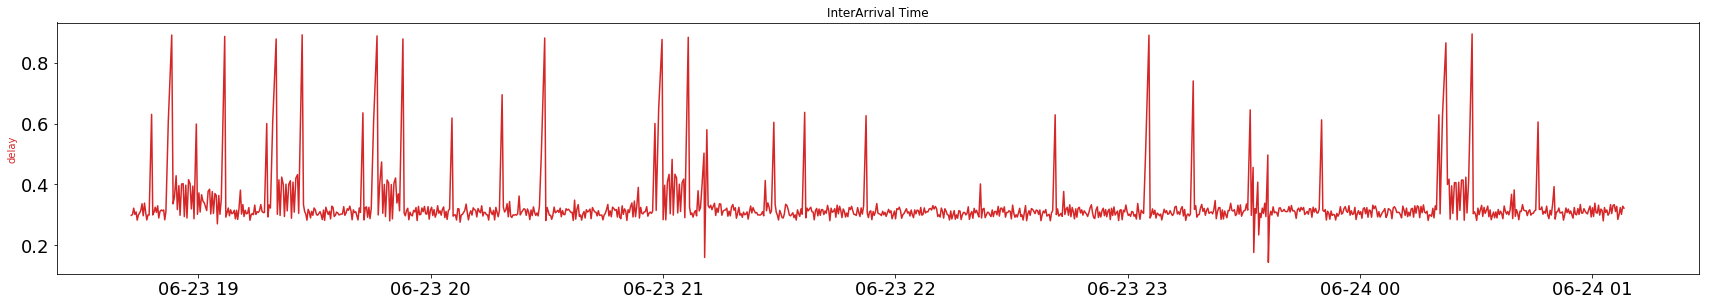

Mote agMote-20009


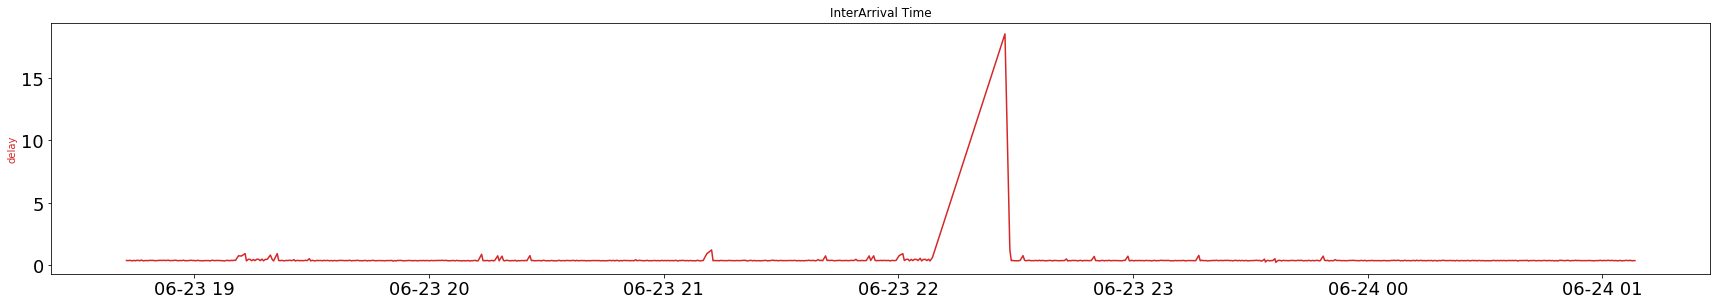

Mote agMote-20010


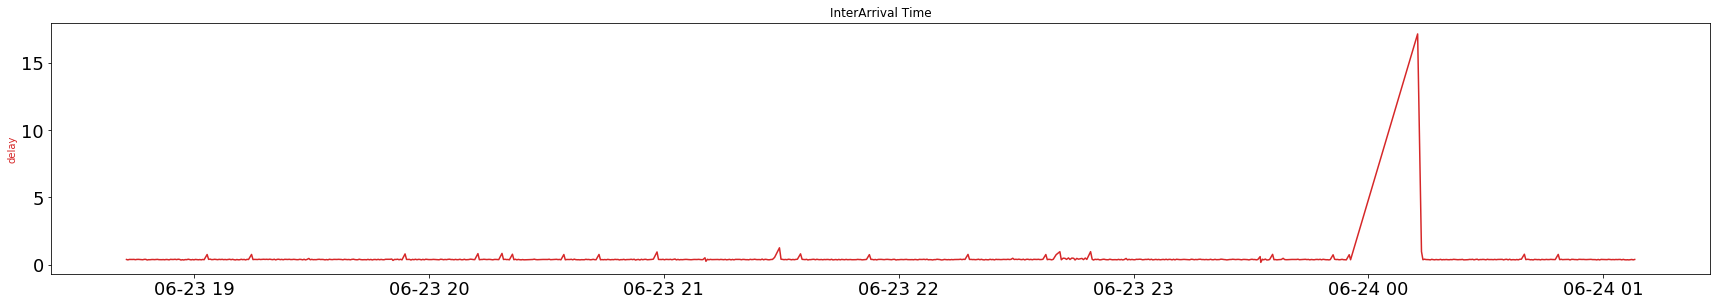

Mote agSound


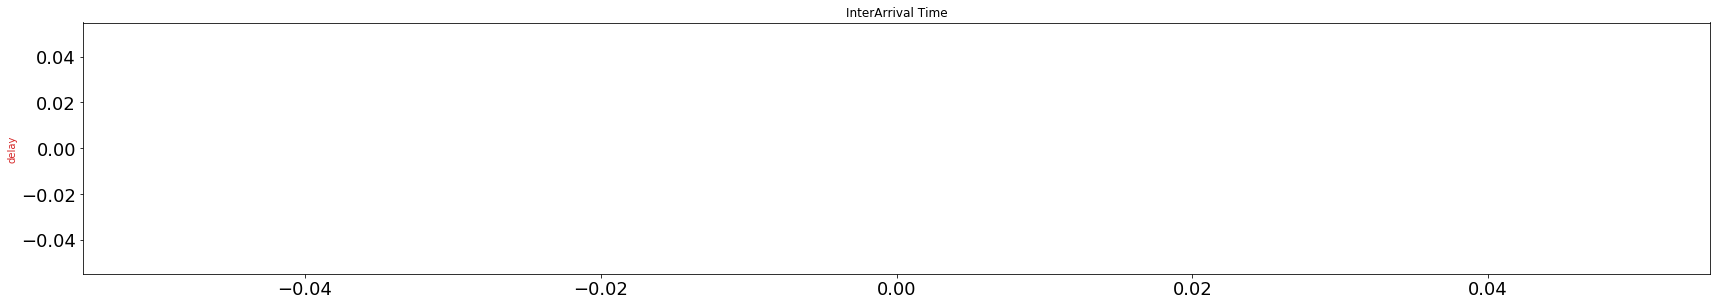

Mote agMote-20000


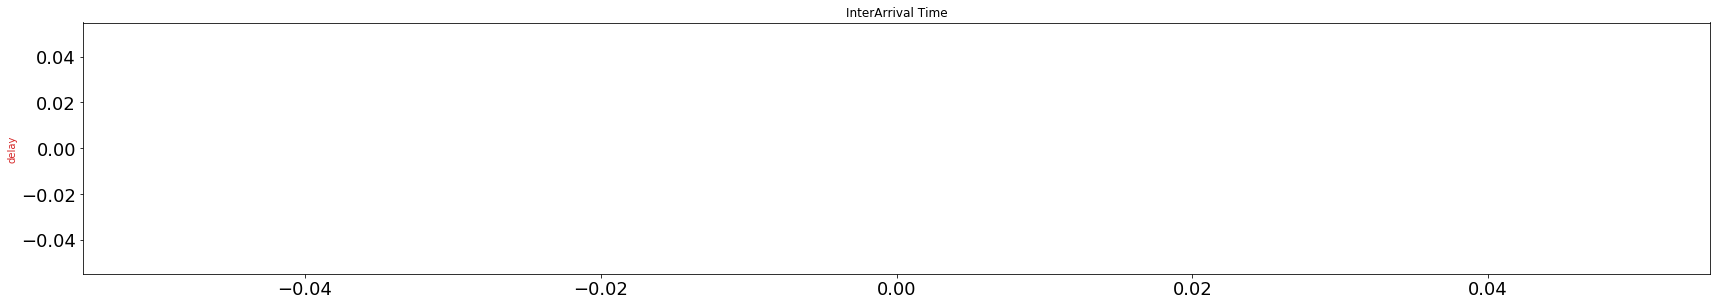

Mote agMote-20003


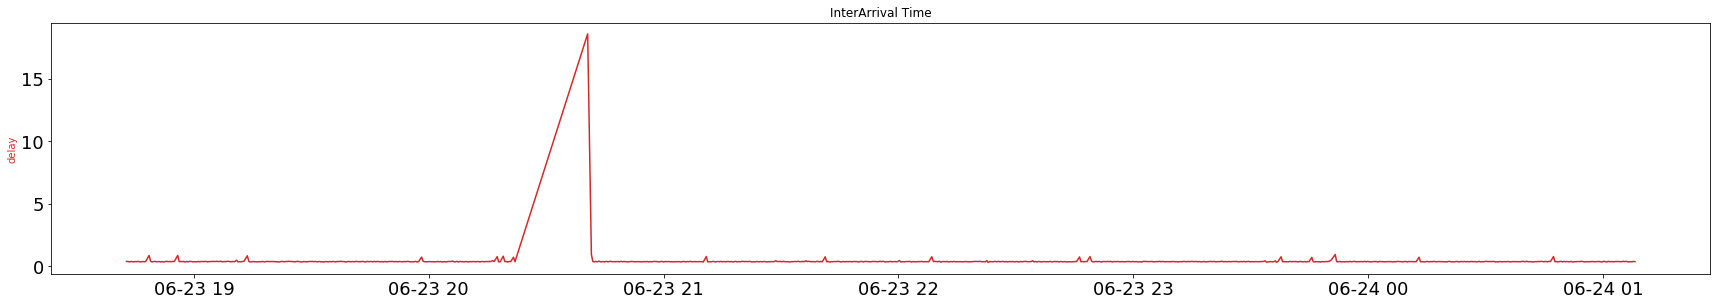

MoteIntervalArrivalTimes Done!


In [71]:
import matplotlib
from matplotlib import pyplot as plt
register_matplotlib_converters()
import numpy as np

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

#_LOG_LEVEL = _LOG_DEBUG

#Mote types
_MAINS_MOTE_TYPE = 10000
_BATTERY_MOTE_TYPE = 10002

now = datetime.now() - timedelta(hours = _UTC_OFFSET)

motequery = "SELECT * FROM kanji_node WHERE deploystate_id=10001 AND (nodetype_id={} OR nodetype_id={})".format(_MAINS_MOTE_TYPE, _BATTERY_MOTE_TYPE)
logger(_LOG_DEBUG, motequery)
df = pd.read_sql(motequery, conn)

logger(_LOG_DEBUG, "number of motes {}".format(len(df.index)))
for ind in df.index:
    query = "SELECT date_trunc('second', timestamp) AS timechunk, (timestamp - lag(timestamp, 1) OVER (ORDER BY timestamp)) AS delta \
             FROM kanji_eventlog WHERE node_id={} AND timestamp > NOW() - INTERVAL '6 HOURS' ORDER BY timestamp desc;".format(df['idnode'][ind])
    
    #logger(_LOG_DEBUG, query)
    df2 = pd.read_sql(query, conn)
    df2 = df2[:-1]
    df2['delta'] = df2['delta'] / np.timedelta64(1, 'm')
    logger(_LOG_DEBUG, df2.head(10))
    ts1 = df2.set_index('timechunk')
    # Plot the profile
    fig = plt.figure(figsize=(24,8))
    fig.subplots_adjust(top=0.8)
        
    pcolor = 'tab:red'
    tcolor = 'tab:blue'
    hcolor = 'tab:green'
        
    ax1 = fig.add_subplot(211)
    ax1.set_ylabel('delay', color=pcolor)
    #ax1.set_ylim([0, 1])
    #ax1.set_xlim([starttime, now])         
      
    ax1.set_title('InterArrival Time')
    ax1.plot(ts1, color=pcolor)
    
    plt.tight_layout()
    logger(_LOG_INFO, "Mote {}".format(df['name'][ind]))
    plt.show()
    
logger(_LOG_INFO, "MoteIntervalArrivalTimes Done!")  